# LLM Deduction-Benchmark Analysis

Three models  
* mistral-7b-instruct 
* llama-2 3B chat
* phi-2

evaluated on N deduction and N abduction tasks.  
This notebook loads the JSON result files, computes basic accuracy metrics, and explores performance vs. task characteristics such as proof-depth and rule / fact counts.

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.utils import shuffle

files = {
    "mistral": Path("results/mistral_deduction_results.json"),
    "llama" : Path("results/llama2_deduction_results.json"),
    "phi": Path("results/phi2_deduction_results.json"),
}
# ------------------------------------------------------------------

records = []
for model, fp in files.items():
    with open(fp) as f:
        data = json.load(f)
    for d in data:
        records.append({**d, "model": model})

df = pd.DataFrame(records)
print(f"Loaded {df.shape[0]} rows")

# df = shuffle(df)
df.head()

Loaded 425 rows


,num_rules,max_body_length,allow_recursion,branching_factor,proof_depth,num_base_facts,depth,reasoning_type,pred,gold,model,min_proof_depth
377,4,3,False,2,1.0,12,1,deduction,NO,YES,phi,NaN
31,4,3,False,2,1.0,12,not applicable,deduction,NO,NO,mistral,NaN
141,12,3,False,2,1.0,12,not applicable,deduction,YES,NO,flan,NaN
147,8,3,False,2,2.0,8,not applicable,deduction,NO,NO,flan,NaN
85,4,3,False,2,2.0,8,not applicable,deduction,NO,NO,flan,NaN


## Overall Accuracy

In [47]:
df["correct"] = df["gold"] == df["pred"]

acc = df.groupby("model")["correct"].mean().mul(100).round(1)
display(acc.to_frame("accuracy %"))

,accuracy %
model,
flan,54.1
gptneo,58.8
llama,58.8
mistral,58.8
phi,58.8


## Accuracy by Proof Depth

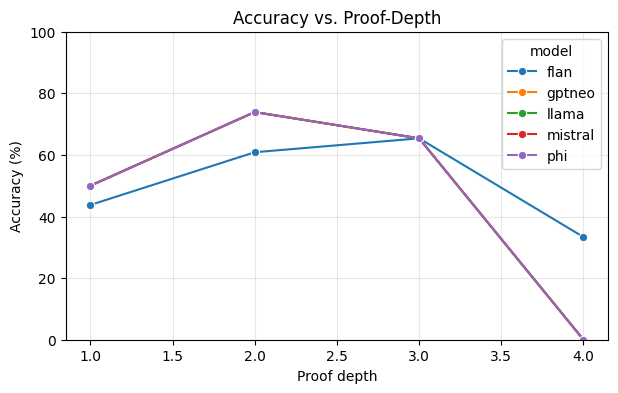

In [48]:
depth_acc = (
    df.groupby(["model", "proof_depth"])["correct"]
      .mean()
      .reset_index()
      .assign(accuracy=lambda x: x["correct"]*100)
)

plt.figure(figsize=(7,4))
sns.lineplot(
    data=depth_acc,
    x="proof_depth", y="accuracy", hue="model", marker="o"
)
plt.title("Accuracy vs. Proof-Depth")
plt.ylabel("Accuracy (%)")
plt.xlabel("Proof depth")
plt.ylim(0,100)
plt.grid(alpha=.3)
plt.show()

## Accuracy by Rule Count

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


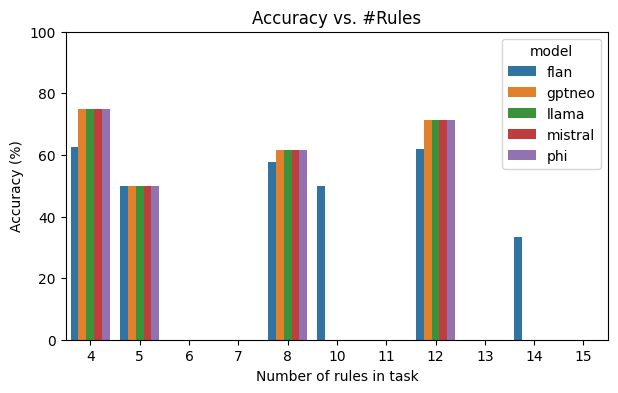

In [49]:
rules_acc = (
    df.groupby(["model", "num_rules"])["correct"]
      .mean()
      .reset_index()
      .assign(accuracy=lambda x: x["correct"]*100)
)

plt.figure(figsize=(7,4))
sns.barplot(
    data=rules_acc, x="num_rules", y="accuracy", hue="model"
)
plt.title("Accuracy vs. #Rules")
plt.ylabel("Accuracy (%)")
plt.xlabel("Number of rules in task")
plt.ylim(0,100)
plt.show()

## Confusion matrix-like view

In [50]:
pd.crosstab(df["gold"], df["pred"], margins=True)

pred,NO,YES,All
gold,,,
NO,242,8,250
YES,171,4,175
All,413,12,425


## Hardest questions per model
Investigate these in more detail -> try to understand why these might be more difficult